# 0. Introduction

(a bit messy) notebook for determining thresholds on scan size (when to cut off a scan), and bowel bag annotations upper (when to cut off the annotation) and lower (when to consider an annotation missing) thresholds. We do all this relative to the location of the end of the hip annotation to remove as much variance as possible.

* Section 1: some graphs and analysis
  * Section 1.1: Conclusion:
        * Scan size threshold: 108 (to capture most of the first peak in the multi-modal distribution of scan sizes)
        * Bowel bag annotation lower threshold: 47 (25 percentile)
        * Bowel bag annotation upper threshold: 61 (just high enough to capture the first peak in the distribution and to cover the most common bowel bag annotation style)
* Section 2: applying the determined thresholds to the dataset (adding some columns for the dataloader to use to cut off scans/annoations), creating an updated dataset (meta dataframe),
* Section 3: write the updated dataset metadata

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [3]:
# import sys
# sys.path.append('../../experiments/unet/')

In [4]:
# import torch_AMCDataset
# from importlib import reload  

# reload(torch_AMCDataset)

# 1. Analyse scan & bowel bag start/endings to determine thresholds

In [5]:
root_dir = '/export/scratch2/bvdp/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split_preprocessed_21-08-2020/'
meta_path = "/export/scratch3/bvdp/segmentation/OAR_segmentation/data_preparation/meta/dataset_train_21-08-2020.csv"

In [6]:
results = {}
classes = ['background', 'bowel_bag', 'bladder', 'hip', 'rectum']

meta_df = pd.read_csv(meta_path)
meta_df = meta_df[(meta_df[classes[1:]] >= 1).all(axis=1)].reset_index()
for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
    np_filepath = f'{os.path.join(row.path, row.SeriesInstanceUID)}.npz'
    with np.load(np_filepath) as datapoint:
        vol, mask = datapoint['volume'], datapoint['mask_volume']
 
    n_slices = mask.shape[0]
    for cls, cls_idx in zip(classes, range(len(classes))):
        slices = np.where((mask == cls_idx).any(axis=(1,2)))[0]        
        slices_mask = pd.Series(slices >= 0, index=slices).reindex(range(n_slices)).fillna(False).values
        cls_results = results.get(cls, [])
        cls_results.append(slices_mask)
        results[cls] = cls_results

  0%|          | 0/186 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame(results, index=meta_df.index) \
    .join(meta_df.drop(['bowel_bag', 'bladder', 'hip', 'rectum'], axis=1))
df_train = df[df.train]
df_train.head(2)

,background,bowel_bag,bladder,hip,rectum,index,Modality,PatientPosition,PixelSpacing,RescaleIntercept,...,desired_slice_thickness,input_directory,labels,npixels,orientation,origin,path,root_path,patient_id,train
0,"[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",1,CT,HFS,"[0.976562, 0.976562]",-1024.0,...,2.5,/export/scratch2/bvdp/Data/Projects_DICOM_data...,rectum|bladder|bowel_bag|hip,"[512, 512]",Transverse,"[-250.0, -250.0, 115.0]",/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,2636097697_3613183264,True
1,"[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",2,CT,HFS,"[0.976562, 0.976562]",-1024.0,...,2.5,/export/scratch2/bvdp/Data/Projects_DICOM_data...,rectum|bladder|bowel_bag|hip,"[512, 512]",Transverse,"[-250.0, -250.0, 12.5]",/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,2636097697_3613183264,True


In [8]:
# df_test = pd.DataFrame(results_test, index=dataset_test.meta_df.index) \
#     .join(dataset_test.meta_df.drop(['bowel_bag', 'bladder', 'hip', 'rectum'], axis=1))
# df_test.head(2)

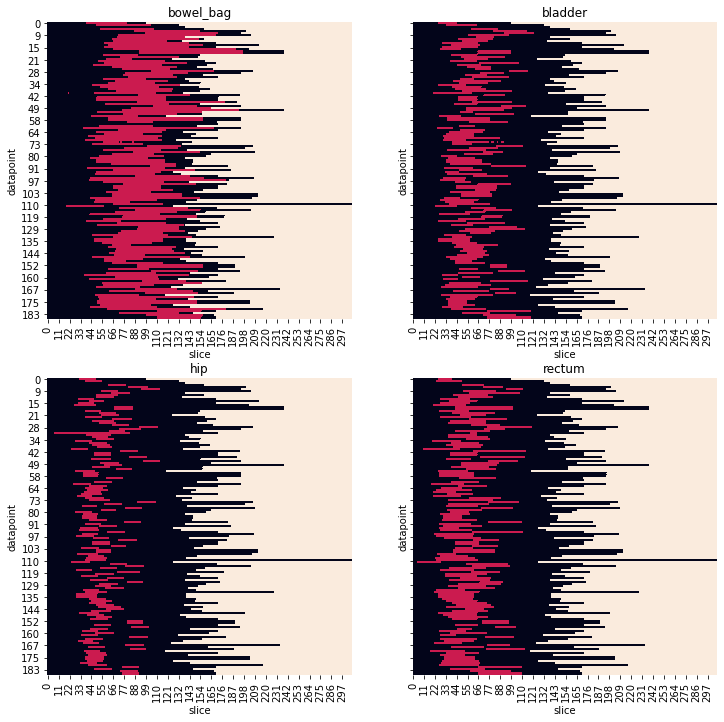

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=False, sharey=True)

for i, cls in enumerate(['bowel_bag', 'bladder', 'hip', 'rectum']):
    df_slice_presence = df_train[cls].apply(pd.Series).astype(float).fillna(2)
#     df_slice_presence = df[cls].apply(lambda x: pd.Series(x > 0, index=x))
#     df_slice_presence = df_slice_presence.reindex(columns=range(0,max_slices)).fillna(False)
    df_slice_presence.columns = df_slice_presence.columns.rename("slice")
    df_slice_presence.index = df_slice_presence.index.rename("datapoint")
    
    ax = axes.ravel()[i]
    sns.heatmap(df_slice_presence, cbar=False, ax=ax)
    ax.set_title(cls);
    

In [10]:
from functools import reduce

<AxesSubplot:>

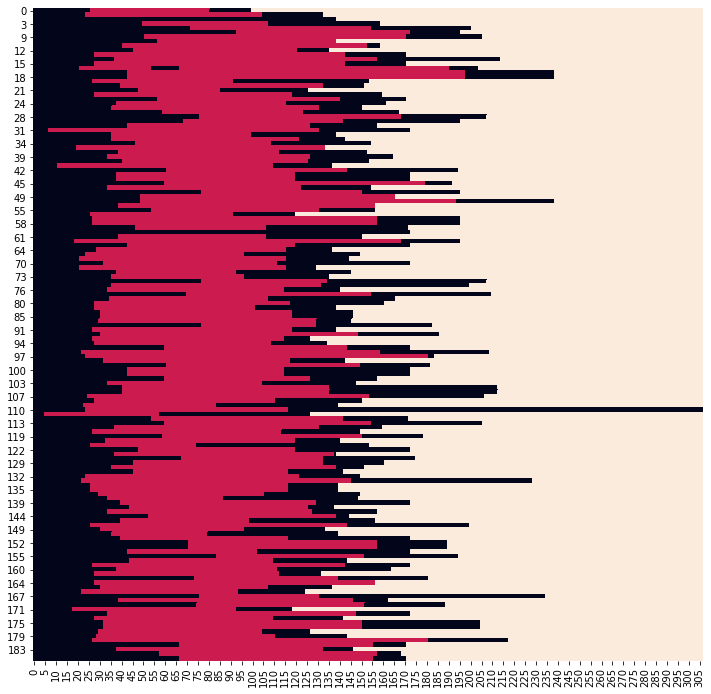

In [11]:
df_classes = df_train[['bowel_bag', 'bladder', 'hip', 'rectum']]
df_presence_any = df_classes.apply(lambda row: reduce(lambda x, y: x | y, row), axis=1).apply(pd.Series).astype(float)
plt.figure(figsize=(12,12))
sns.heatmap(df_presence_any.fillna(2), cbar=False)

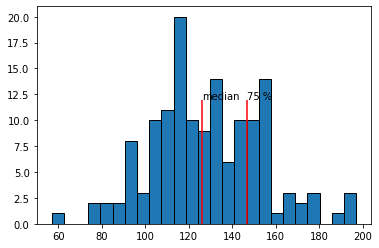

In [12]:
end_slices = df_presence_any.apply(lambda x: x[x == 1].index.max(), axis=1)
ax = end_slices.hist(bins=25, linewidth=1, edgecolor='black', grid=False)
median = end_slices.median()
percentile_75 = end_slices.describe()['75%']
line_height = 12
plt.vlines([median, percentile_75], ymin=0, ymax=line_height, color='red')
ax.annotate("median", (median, line_height))
ax.annotate("75 %", (percentile_75, line_height));

In [13]:
df_presence_any.apply(lambda x: x[x == 1].index.max(), axis=1).describe()

count    145.000000
mean     128.324138
std       25.862049
min       57.000000
25%      111.000000
50%      126.000000
75%      147.000000
max      197.000000
dtype: float64

WEIRD. No labels:
* '/export/scratch3/bvdp/segmentation/data/MODIR_data_preprocessed_train_23-04-2020/3476679937_3399399578'


## Inspect slices in train for determining threshold

In [14]:
classes = ['hip', 'bowel_bag', 'bladder', 'rectum', 'background']

In [15]:
starts_ends = []
for cls in classes:
    start = df_train[cls].apply(pd.Series).apply(lambda x: x[x==1].index.min(), axis=1)
    end = df_train[cls].apply(pd.Series).apply(lambda x: x[x==1].index.max(), axis=1)
    size = end-start
    starts_ends.append(pd.DataFrame({f'{cls}_start': start, f'{cls}_end': end, f'{cls}_size': size}))

In [16]:
df_sizes = pd.concat(starts_ends, axis=1)
df_sizes.head()

,hip_start,hip_end,hip_size,bowel_bag_start,bowel_bag_end,bowel_bag_size,bladder_start,bladder_end,bladder_size,rectum_start,rectum_end,rectum_size,background_start,background_end,background_size
0,32.0,49.0,17.0,40.0,80.0,40.0,26.0,44.0,18.0,26.0,39.0,13.0,0,99,99
1,38.0,55.0,17.0,50.0,104.0,54.0,34.0,64.0,30.0,24.0,49.0,25.0,0,132,132
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,138,138
3,62.0,79.0,17.0,54.0,107.0,53.0,59.0,86.0,27.0,50.0,72.0,22.0,0,158,158
4,82.0,101.0,19.0,88.0,154.0,66.0,82.0,115.0,33.0,72.0,91.0,19.0,0,200,200


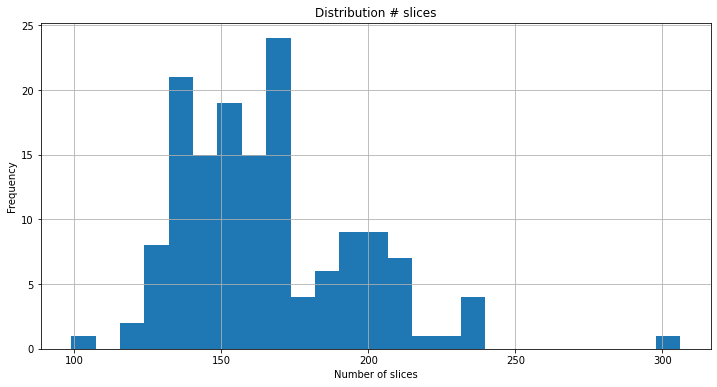

In [17]:
df_sizes.background_size.plot.hist(bins=25, figsize=(12,6), title='Distribution # slices')
plt.grid()
plt.xlabel("Number of slices");

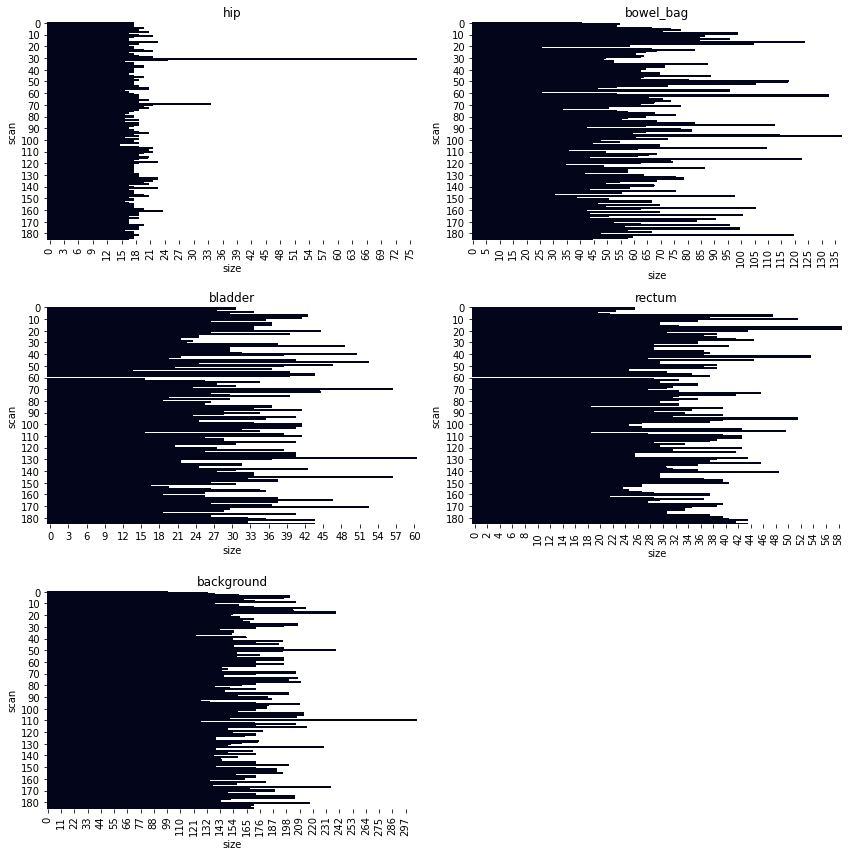

In [18]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

for i, cls in enumerate(classes):
    ax = axes.ravel()[i]
    sns.heatmap(df[cls].apply(pd.Series).apply(lambda x: x[x==1].reset_index(drop=True), axis=1).astype(float), ax=ax, cbar=False)
    ax.set_title(f'{cls}')
    ax.set_xlabel('size')
    ax.set_ylabel('scan')
fig.tight_layout()
fig.delaxes(axes[2][1])
# fig.savefig('annotation_sizes.png')

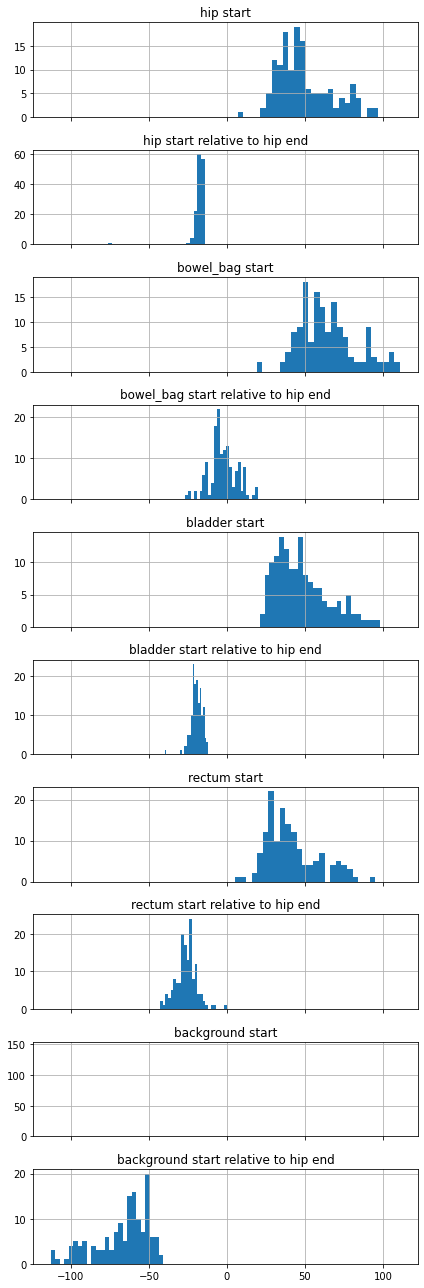

In [19]:
fig, axes = plt.subplots(10,1, sharex=True, figsize=(6,18))
for i, cls in enumerate(classes):
    ax1 = axes.ravel()[i*2]
    ax2 = axes.ravel()[i*2+1]
    (df_sizes[f'{cls}_start'] - df_sizes.hip_end).hist(bins=25, ax=ax2)
    (df_sizes[f'{cls}_start']).hist(bins=25, ax=ax1)
    ax1.set_title(f'{cls} start')
    ax2.set_title(f'{cls} start relative to hip end')
    
plt.tight_layout()
# fig.savefig('starts_relative_to_hip.png')

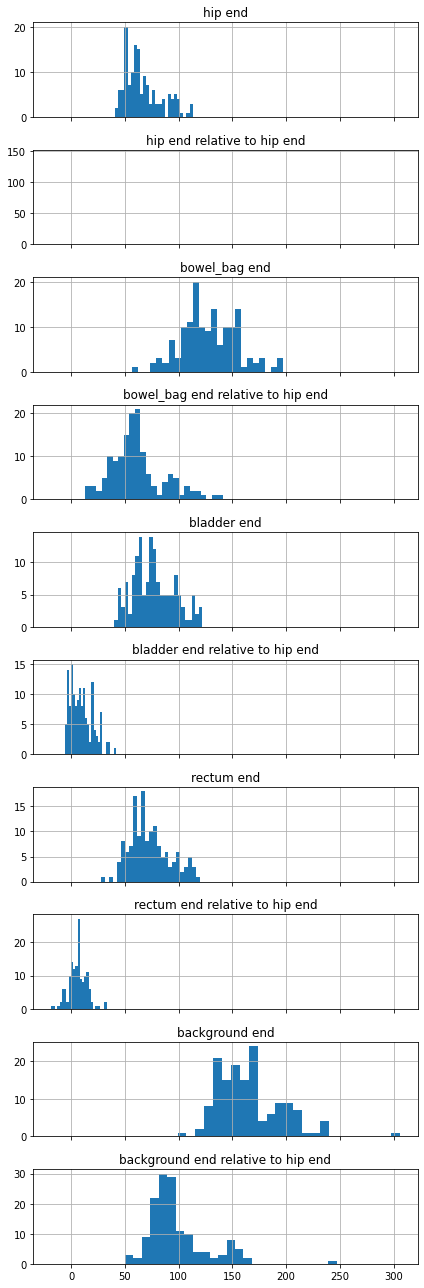

In [20]:
fig, axes = plt.subplots(10,1, sharex=True, figsize=(6,18))
for i, cls in enumerate(classes):
    ax1 = axes.ravel()[i*2]
    ax2 = axes.ravel()[i*2+1]
    (df_sizes[f'{cls}_end'] - df_sizes.hip_end).hist(bins=25, ax=ax2)
    (df_sizes[f'{cls}_end']).hist(bins=25, ax=ax1)
    ax1.set_title(f'{cls} end')
    ax2.set_title(f'{cls} end relative to hip end')
    
plt.tight_layout()
# fig.savefig('ends_relative_to_hip.png')

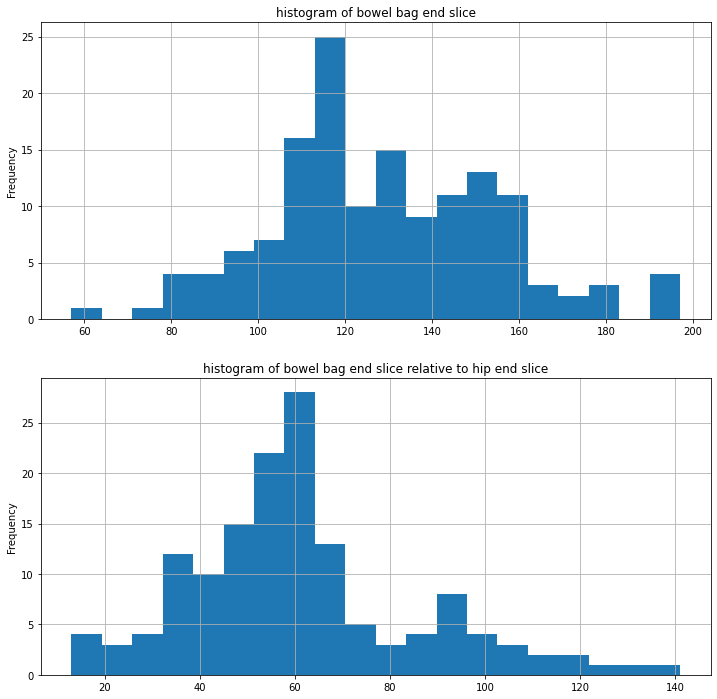

In [21]:
fig, ax = plt.subplots(2,1, figsize=(12,12))
df_sizes['bowel_bag_end'].plot.hist(bins=20, ax=ax[0], title='histogram of bowel bag end slice')
(df_sizes['bowel_bag_end'] - df_sizes.hip_end).plot.hist(bins=20, ax=ax[1], title='histogram of bowel bag end slice relative to hip end slice')
ax[0].grid()
ax[1].grid()
# fig.savefig('bowel_bag_end_slice_histograms.png')

<AxesSubplot:>

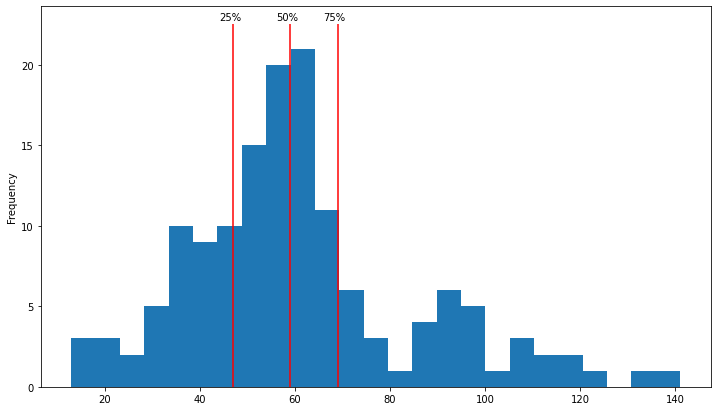

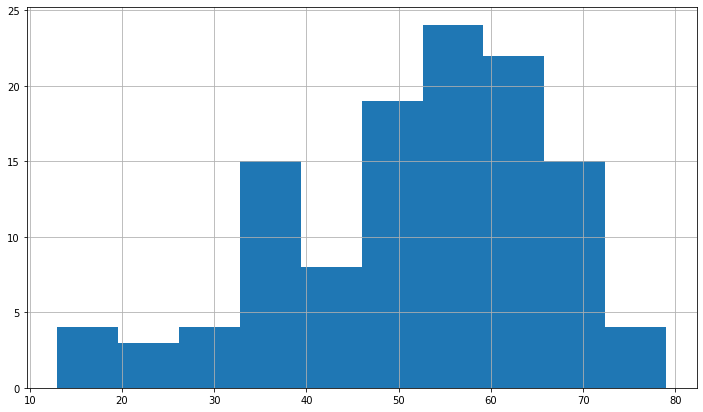

In [22]:
bowel_bag_ends_rel_hip = (df_sizes['bowel_bag_end'] - df_sizes.hip_end)
bowel_bag_ends_rel_hip.plot.hist(bins=25, figsize=(12,7))
bb_stats = bowel_bag_ends_rel_hip.describe()
plt.vlines([bb_stats['25%'], bb_stats['50%'], bb_stats['75%']], ymin=0, ymax=22.5, color='red')
# plt.vlines([bb_stats['25%'], bb_stats['50%'], bb_stats['75%']], ymin=0, ymax=0.02, color='red')
plt.annotate('25%', (bb_stats['25%']-3, 22.75))
plt.annotate('50%', (bb_stats['50%']-3, 22.75))
plt.annotate('75%', (bb_stats['75%']-3, 22.75))
plt.figure()
bowel_bag_ends_rel_hip[bowel_bag_ends_rel_hip < 80].hist(bins=10, figsize=(12,7))

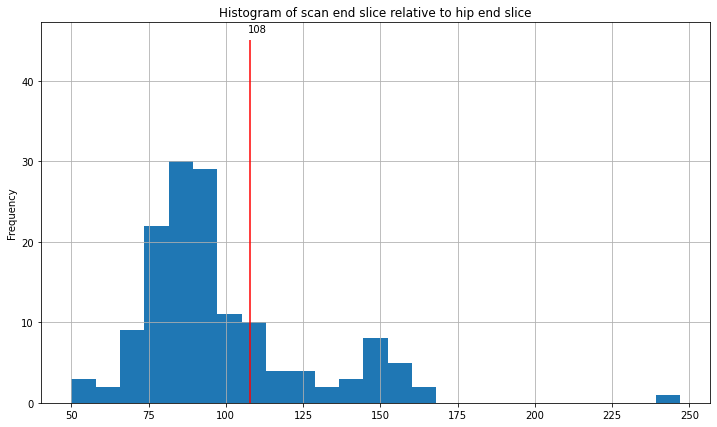

In [23]:
scans_end_rel_hip = (df_sizes['background_end'] - df_sizes.hip_end)
scans_end_rel_hip.plot.hist(bins=25, figsize=(12,7))
plt.vlines([108], ymin=0, ymax=45, color='red')
plt.annotate('108', (108-1, 46))
plt.title("Histogram of scan end slice relative to hip end slice");
# plt.ylabel
# plt.figure()
# scans_end_rel_hip[scans_end_rel_hip < 130].plot.hist(bins=25, figsize=(12,7))
plt.grid()
# plt.savefig('scan_end_slice_histogram.png')

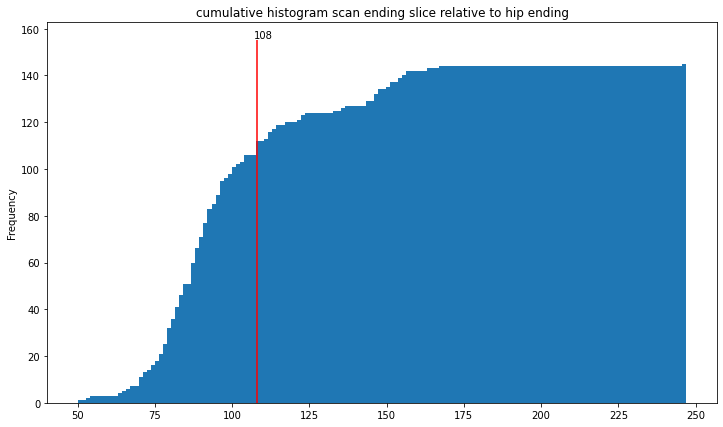

In [24]:
scans_end_rel_hip.plot.hist(cumulative=True, bins=150, figsize=(12,7))
plt.vlines([108], ymin=0, ymax=155, color='red')
plt.annotate('108', (110-3, 156))
plt.title('cumulative histogram scan ending slice relative to hip ending');
# plt.savefig('scan_end_slice_histogram_cumulative.png')

## 1.1 Conclusion
* Scan size threshold: 108 (to capture most of the first peak in the multi-modal distribution of scan sizes)
* Bowel bag annotation lower threshold: 47 (25 percentile)
* Bowel bag annotation upper threshold: 61 (just high enough to capture the first peak in the distribution and to cover the most common bowel bag annotation style)

# 2.  Apply thresholds and create new metadata frame containing the applied thresholds for use in the updated torch_AMCDataset

In [25]:
df_for_annot = df

starts_ends = []
for cls in classes:
    start = df_for_annot[cls].apply(pd.Series).apply(lambda x: x[x==1].index.min(), axis=1)
    end = df_for_annot[cls].apply(pd.Series).apply(lambda x: x[x==1].index.max(), axis=1)
    size = end-start
    starts_ends.append(pd.DataFrame({f'{cls}_start': start, f'{cls}_end': end, f'{cls}_size': size}))

In [26]:
df_sizes = pd.concat(starts_ends, axis=1)
df_sizes.head()

,hip_start,hip_end,hip_size,bowel_bag_start,bowel_bag_end,bowel_bag_size,bladder_start,bladder_end,bladder_size,rectum_start,rectum_end,rectum_size,background_start,background_end,background_size
0,32.0,49.0,17.0,40.0,80.0,40.0,26.0,44.0,18.0,26.0,39.0,13.0,0,99,99
1,38.0,55.0,17.0,50.0,104.0,54.0,34.0,64.0,30.0,24.0,49.0,25.0,0,132,132
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,138,138
3,62.0,79.0,17.0,54.0,107.0,53.0,59.0,86.0,27.0,50.0,72.0,22.0,0,158,158
4,82.0,101.0,19.0,88.0,154.0,66.0,82.0,115.0,33.0,72.0,91.0,19.0,0,200,200


In [27]:
bowel_bag_lower_thresh = 47
bowel_bag_upper_thresh = 61
scan_upper_thresh = 108

In [28]:
annot_df = df_for_annot[['path', 'root_path', 'patient_id','train']] \
    .join((df_sizes.hip_end + bowel_bag_upper_thresh).rename('end_slice_annotation').to_frame()) \
    .join((df_sizes.hip_end + scan_upper_thresh).rename('end_slice_scan').to_frame()) \
    .join((df_sizes.bowel_bag_end - df_sizes.hip_end).rename('bowel_bag_end_hip_offset').to_frame()) \
    .sort_values(['patient_id'])

annot_df = annot_df \
    .assign(
        missing_annotation=(~(annot_df.bowel_bag_end_hip_offset > bowel_bag_lower_thresh)).astype(int)) \
    .loc[:,['path', 'root_path', 'end_slice_annotation', 'end_slice_scan', 'missing_annotation']]
annot_df.head(3)

,path,root_path,end_slice_annotation,end_slice_scan,missing_annotation
133,/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,121.0,168.0,0
51,/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,149.0,196.0,0
64,/export/scratch2/bvdp/Data/Projects_DICOM_data...,/export/scratch2/bvdp/Data/Projects_DICOM_data...,117.0,164.0,0


**(Change meta_path to path of test dataset to do the same thing for the test set)**

In [29]:
from pathlib import Path

# meta_path = "/export/scratch3/bvdp/segmentation/OAR_segmentation/data_preparation/meta/dataset_train_21-08-2020.csv"
meta_df = pd.read_csv(meta_path)
meta_df = meta_df.assign(
    end_path=meta_df.apply(lambda x: Path(x.path).relative_to(Path(x.root_path)), axis=1)
)

## OLD: bit of a hack to join annotations based on older meta dataframe with different paths
# annot_df_root_path = '/export/scratch2/bvdp/Data/Projects_DICOM_data/ThreeD/MODIR_data_train_split_preprocessed_25-06-2020/'
annot_df = annot_df.assign(
    end_path=annot_df.apply(lambda x: Path(x.path).relative_to(Path(x.root_path)), axis=1)
#     end_path=annot_df.apply(lambda x: Path(x.path).relative_to(Path(annot_df_root_path)), axis=1)
).drop(['path','root_path'], axis=1)

In [30]:
# meta_with_annot = meta_df.merge(annot_df, on='path')
meta_with_annot = meta_df.merge(annot_df, on='end_path')
meta_with_annot.head()

,Modality,PatientPosition,PixelSpacing,RescaleIntercept,RescaleSlope,SeriesInstanceUID,SliceThickness,WindowCenter,WindowWidth,desired_pixel_spacing,...,patient_id,bladder,rectum,bowel_bag,hip,train,end_path,end_slice_annotation,end_slice_scan,missing_annotation
0,CT,HFS,"[0.976562, 0.976562]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.5,40.0,400.0,"[2.5, 2.5]",...,2636097697_3613183264,1,1,1,1,True,2636097697_3613183264/20160108,110.0,157.0,1
1,CT,HFS,"[0.976562, 0.976562]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.5,40.0,400.0,"[2.5, 2.5]",...,2636097697_3613183264,1,1,1,1,True,2636097697_3613183264/20151223,116.0,163.0,0
2,CT,HFP,"[1.171875, 1.171875]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,3.0,"[50.0, 50.0]","[400.0, 400.0]","[2.5, 2.5]",...,2475058207_640932983,1,1,1,1,True,2475058207_640932983,NaN,NaN,1
3,CT,HFS,"[0.976562, 0.976562]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.5,40.0,400.0,"[2.5, 2.5]",...,840965848_3386505119,1,1,1,1,True,840965848_3386505119,140.0,187.0,1
4,CT,HFS,"[0.976562, 0.976562]",-1024.0,1.0,1.2.826.0.1.3680043.2.135.737157.54716028.7.15...,2.5,40.0,400.0,"[2.5, 2.5]",...,1264716875_2710935007,1,1,1,1,True,1264716875_2710935007,162.0,209.0,0


# 3. Write new metadata frame 

In [ ]:
# meta_with_annot.to_csv('../meta/dataset_train_21-08-2020_slice_annot.csv', index=False)